In [1]:
import pickle
import numpy as np
import pandas as pd

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('ggplot')
plt.rc('figure', autolayout=True)

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
plt.rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':12})
# Set the font used for MathJax - more on this later
plt.rc('mathtext',**{'default':'regular'})
%config InlineBackend.figure_format = 'retina'

In [3]:
scores = pd.read_excel('T2V_HR_scores_240123.xlsx', index_col=0).T
# scores.columns = ["Coherence", "IRBO"]

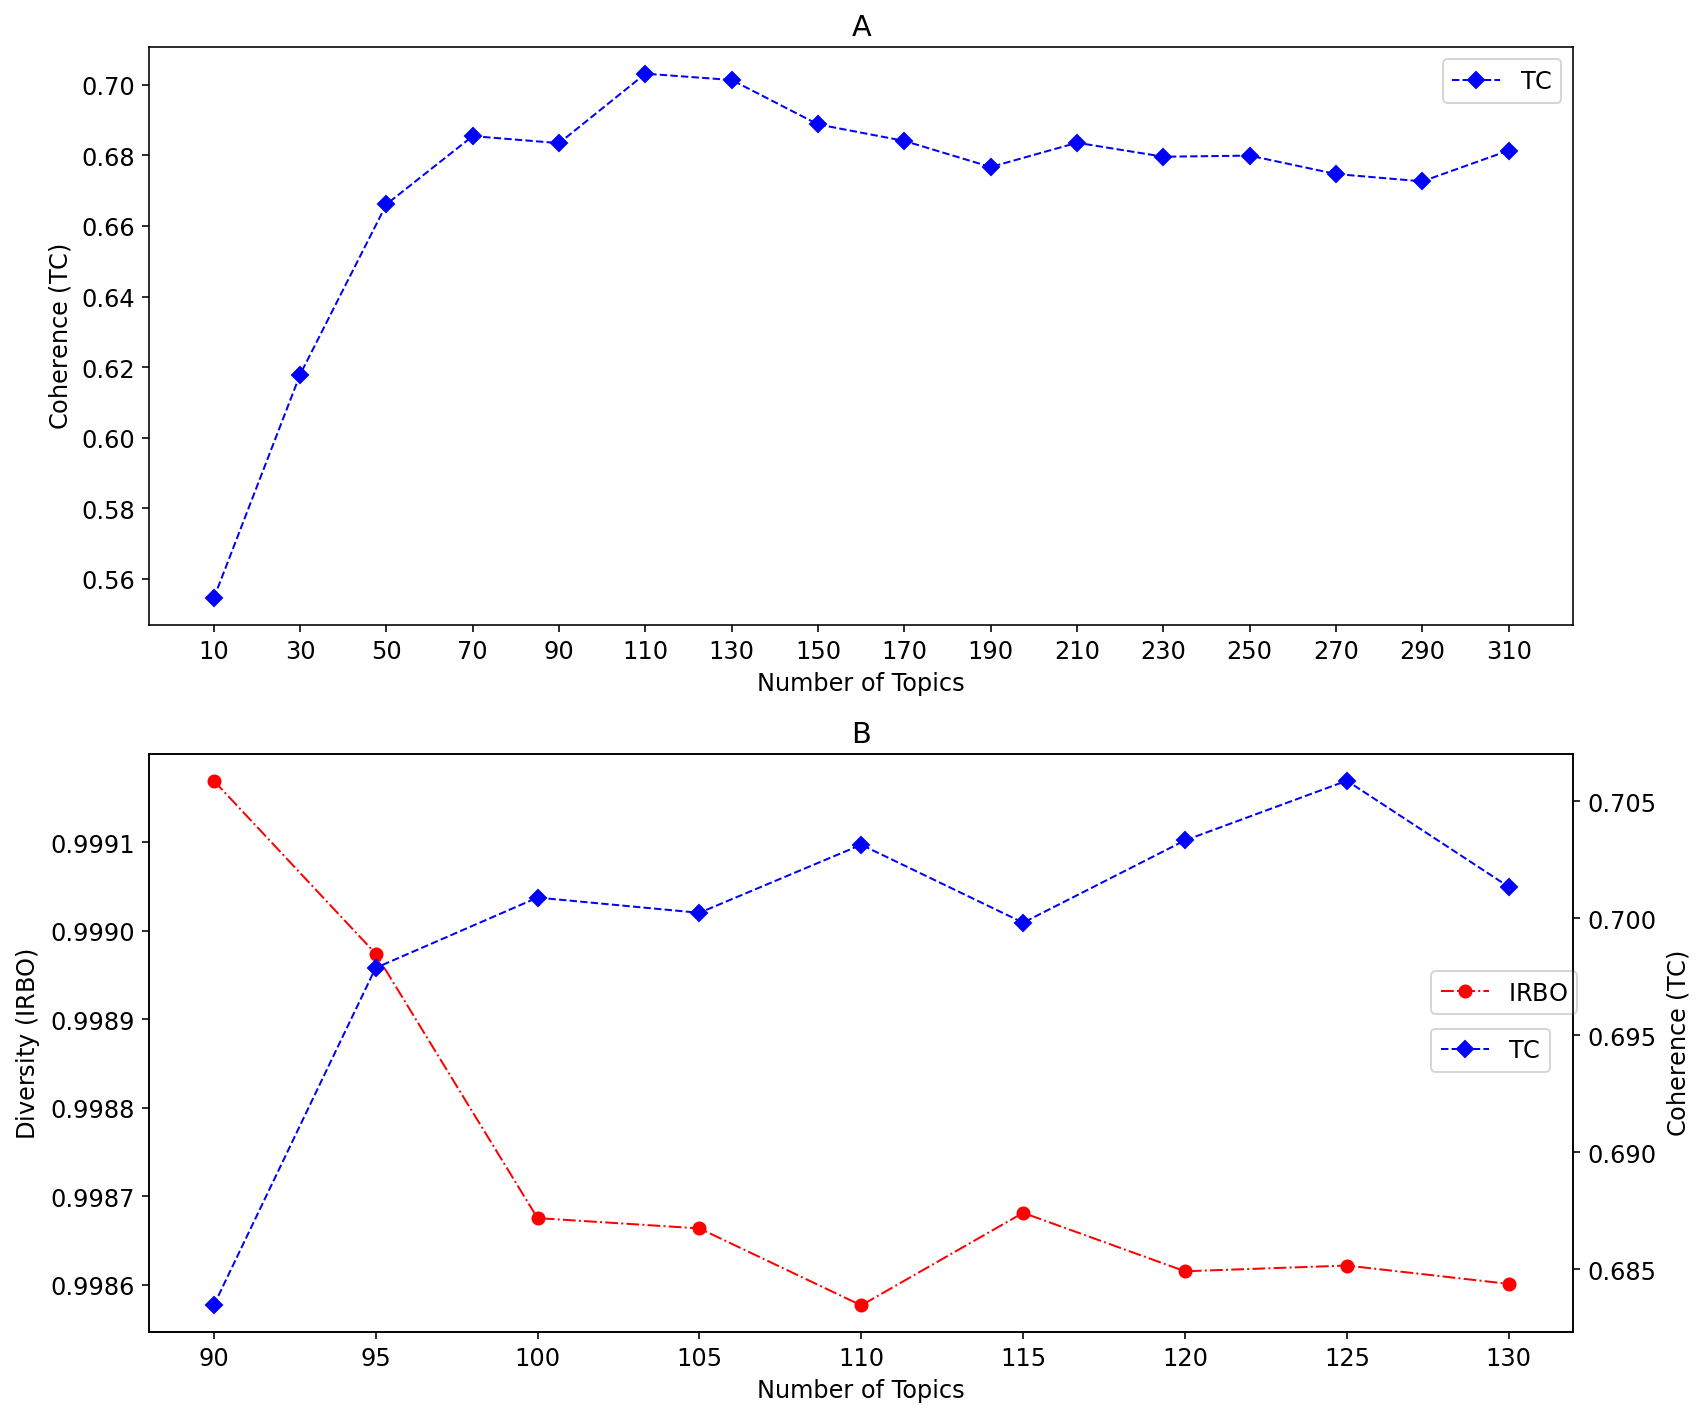

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(12,10))
ax[0].plot(
    range(10, 311, 20), 
    scores.loc[range(10, 311, 20), "Coherence"], 
    ls='--', marker='D', color='b', label='$TC$', lw=1
)
ax[0].set_xticks(range(10, 311, 20))
ax[0].set_xlabel('Number of Topics')
ax[0].set_ylabel('Coherence ($TC$)')
ax[0].legend(loc='best')
ax[0].set_title("A")

ax2 = ax[1].twinx()
ax[1].plot(
    range(90, 131, 5), 
    scores.loc[range(90, 131, 5), 'IRBO'], 
    ls='-.', marker='o', color='r', label='$IRBO$', lw=1
)
ax[1].set_xlabel('Number of Topics')
ax[1].set_ylabel('Diversity ($IRBO$)')
ax[1].grid(False, axis='y')

ax2.plot(
    range(90, 131, 5), 
    scores.loc[range(90, 131, 5), 'Coherence'], 
    ls='--', marker='D', color='b', label='$TC$', lw=1
)
ax2.set_ylabel('Coherence ($TC$)')
ax2.grid(False, axis='y')

ax[1].legend(loc=(0.9,0.55))
ax2.legend(loc=(0.9,0.45))

ax[1].set_title("B")

plt.savefig("HReduction.png", dpi=600)
plt.show()

In [2]:
train_docs_df = pd.read_csv('..\Data\clean_docs_3.csv')
train_docs_df.head()

,rf_seq,CIK,report_dt,filing_dt,cleaned_txt,category,SIC,Industry
0,0,20,2006-12-30,2007-03-09,business operation subject number risk uncerta...,NaN,3823,Office of Life Sciences
1,1,20,2006-12-30,2007-03-09,competition adversely affect business result o...,NaN,3823,Office of Life Sciences
2,2,20,2006-12-30,2007-03-09,substantial sale abroad subject risk adverse f...,NaN,3823,Office of Life Sciences
3,3,20,2006-12-30,2007-03-09,operate cyclical industry industrial capital g...,NaN,3823,Office of Life Sciences
4,4,20,2006-12-30,2007-03-09,loss large customer adverse effect operating r...,NaN,3823,Office of Life Sciences


# All topics

In [28]:
T2V_df = pd.read_csv("T2V_df_H85.csv")

T2V_df = T2V_df.drop(columns="Docs").set_index("index")

In [39]:
RF_topic_df = pd.merge(left=train_docs_df, right=T2V_df[["Topic", "Score", "Topic_H", "Score_H"]], how='left', left_index=True, right_index=True)

RF_topic_df['filing_yr'] = RF_topic_df['filing_dt'].map(lambda x: str(x)[:4])
RF_topic_df['report_yr'] = RF_topic_df['report_dt'].map(lambda x: str(x)[:4])

In [5]:
RFs_all = pd.read_csv('..\Data\RFs_all.csv', index_col=0)
RFs_all['rf_seq'] = RFs_all.groupby(['CIK', 'report_dt', 'filing_dt']).rank(method='first').index

c:\Users\u0147656\Anaconda3\envs\ETM_env\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
max_idx = RF_topic_df.groupby('Topic_H')['Score_H'].nlargest(3).index.get_level_values(1)
min_idx = RF_topic_df.groupby('Topic_H')['Score_H'].nsmallest(3).index.get_level_values(1)

In [7]:
validation_df = RF_topic_df.loc[
    max_idx.append(min_idx),
    ['CIK', 'report_dt', 'filing_dt', 'cleaned_txt', 'rf_seq', 
     "Topic_H", "Score_H", "Topic", "Score"]
]

In [9]:
validation_df = pd.merge(
    left=validation_df, right=RFs_all, 
    on=['CIK', 'report_dt', 'filing_dt', 'rf_seq'],
    how='left'
).sort_values(["Topic_H", "Score_H"]).drop(columns=['filing_dt', 'cleaned_txt', 'rf_seq'])

In [10]:
validation_df.to_html('T2V validation.html', index=False)

In [ ]:
top_count = T2V_df.value_counts('Topic').sort_values()
fig = plt.figure(figsize=(12,8))
top_count.plot.hist(bins=1000)
plt.title("T2V topics frequencies")
# plt.savefig("..\Results\T2V_hist.png")
plt.show()

In [11]:
T2V_tw = pd.read_csv("T2V_tw_H95.csv", index_col=0)

T2V_tw.rename(columns={"0": "Count", "0.1": 0}, inplace=True)

In [18]:
topic_words = T2V_tw.drop(columns='Count').apply(lambda x: ' - '.join(x), axis=1)
topic_words.rename('topic_words', inplace=True)
topic_words.reset_index().to_html('T2V topics.html', index=False)

In [28]:
disc_cnt = RF_topic_df.groupby('Topic')["CIK"].nunique()

In [38]:
g_25 = disc_cnt[(disc_cnt<=disc_cnt.quantile(0.25))].index.to_list()

g_50 = disc_cnt[
    (disc_cnt<=disc_cnt.quantile(0.50))&
    (disc_cnt>disc_cnt.quantile(0.25))
].index.to_list()

g_75 = disc_cnt[
    (disc_cnt<=disc_cnt.quantile(0.75))&
    (disc_cnt>disc_cnt.quantile(0.50))
].index.to_list()

g_100 = disc_cnt[(disc_cnt>disc_cnt.quantile(0.75))].index.to_list()

In [49]:
ind_cnt = disc_cnt = RF_topic_df.groupby('Topic')["SIC"].nunique()

In [54]:
year_cnt = disc_cnt = RF_topic_df.groupby('Topic')["report_yr"].nunique()

In [55]:
year_cnt.describe()

count    3766.000000
mean       15.454594
std         1.092743
min         2.000000
25%        15.000000
50%        16.000000
75%        16.000000
max        16.000000
Name: report_yr, dtype: float64

In [7]:
RF_topic_df.groupby('report_yr')["Topic"].nunique()

report_yr
2006    3520
2007    3574
2008    3638
2009    3658
2010    3708
2011    3722
2012    3732
2013    3718
2014    3743
2015    3750
2016    3742
2017    3736
2018    3728
2019    3719
2020    3709
2021    2805
Name: Topic, dtype: int64

In [8]:
RF_topic_df.groupby('report_yr')["Topic"].count() / RF_topic_df.groupby('report_yr')["CIK"].nunique() 

report_yr
2006    24.839796
2007    25.647586
2008    26.440800
2009    27.205019
2010    29.009401
2011    30.934615
2012    32.168191
2013    34.658706
2014    35.891044
2015    37.733786
2016    39.562151
2017    41.895023
2018    43.663701
2019    45.935675
2020    50.135898
2021    40.988701
dtype: float64

In [22]:
covid = [13, 15, 19, 622, 719, 881, 1192, 1477, 1747, 2176, 2568, 2852, 3044, 3328, 3543, 3390, 3482, 3498]

In [28]:
RF_topic_df[RF_topic_df['Topic'].isin(covid)]['cleaned_txt'].iloc[0]

'market operate highly competitive able compete effectively expect encounter additional competition address new market new competitor enter exist market force lower pricing demand service decrease business financial condition result operation cash flow materially adversely affect competitor substantially great resource able use resource adapt_quickly new emerge technology devote great resource promotion sale product service obtain client contract sizable asset purchase investment financing support require addition frequently compete client internal business process information technology capability constitute fix cost client future competition continue emerge large computer hardware_software provider shift business strategy include service competition emerge european indian offshore service provider seek expand market large consulting company seek operational outsourcing opportunity discussion item'

In [6]:
pivot_1 = pd.pivot_table(
        RF_topic_df, index = 'report_yr', 
        columns='Topic_H', values='CIK', 
        aggfunc='nunique', fill_value=0
    )

pivot_1

Topic_H,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
report_yr,,,,,,,,,,,,,,,,,,,,,
2006,939,741,989,578,634,897,232,794,851,233,...,119,107,222,311,96,106,169,300,167,67
2007,964,741,1061,617,640,942,222,815,805,231,...,107,225,228,290,102,94,176,296,190,70
2008,1146,980,1314,1249,781,1151,328,924,928,264,...,118,459,285,319,147,146,187,336,264,104
2009,1217,1036,1336,1450,815,1204,316,959,936,288,...,135,454,310,371,151,124,208,343,307,137
2010,1219,1076,1362,1340,836,1215,319,998,975,303,...,153,363,323,374,167,144,227,350,312,134
2011,1243,1089,1401,1370,888,1224,319,1050,914,315,...,172,363,328,415,172,144,254,374,346,120
2012,1258,1061,1357,1311,899,1280,341,1060,916,304,...,180,331,337,411,217,168,255,368,354,101
2013,1048,933,1139,956,746,1062,312,843,721,285,...,179,240,300,352,179,159,236,321,300,72
2014,1322,1202,1385,1162,919,1307,388,1061,917,314,...,191,263,371,438,219,245,268,404,360,101


In [24]:
# pivot_1.T.to_excel("..\Results\T2V_topic_year.xlsx")

In [60]:
pivot_2 = (
    pd.pivot_table(
        RF_topic_df, index = 'Industry', 
        columns='Topic', values='CIK', 
        aggfunc='nunique', fill_value=0
        )
    )

pivot_2

Topic,0,1,2,3,4,5,6,7,8,9,...,3756,3757,3758,3759,3760,3761,3762,3763,3764,3765
Industry,,,,,,,,,,,,,,,,,,,,,
Office of Energy & Transportation,125,538,453,393,200,370,168,183,202,286,...,0,0,7,3,0,0,1,0,0,0
Office of Life Sciences,1069,1254,992,1077,854,962,416,485,317,604,...,1,6,1,1,4,1,3,0,2,4
Office of Manufacturing,773,777,642,676,378,421,523,409,432,503,...,3,0,0,2,1,0,1,2,0,0
Office of Real Estate & Construction,101,523,273,335,144,201,104,120,166,216,...,0,0,0,1,3,3,3,0,2,1
Office of Technology,769,750,646,669,480,451,459,427,373,489,...,2,1,0,3,0,2,0,1,0,1
Office of Trade & Services,688,904,804,790,471,610,383,353,441,693,...,1,1,0,1,4,0,1,3,1,2


In [28]:
pivot_2.T.to_excel("..\Results\T2V_topic_ind.xlsx")

In [9]:
T2V_tw.to_excel("..\Results\T2V_topic_words_H95.xlsx")

# Hierarchically reduced topics

In [ ]:
T2V_df_H = pd.read_csv("T2V_df_3_H.csv", index_col=0)
T2V_df_H.head()

In [6]:
RF_topic_df = pd.merge(left=RF_topic_df, right=T2V_df_H["Topic"], how='left', left_index=True, right_index=True)

In [15]:
RF_topic_df.groupby('Topic_y')['Topic_x'].nunique().describe()

count     100.000000
mean      652.950000
std       274.224798
min       221.000000
25%       425.250000
50%       622.500000
75%       822.500000
max      1394.000000
Name: Topic_x, dtype: float64

In [4]:
T2V_tw = pd.read_csv("T2V_tw_3_H.csv", index_col=0)
T2V_tw.head()

,0,0.1,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
0,39738,infringement_misappropriation,validity_scope,infringement,infringe_misappropriate,intellectual,infringe,infringing,trademark_copyright,litigate,...,consume_distracting,refuse_stop,characterize_vigorous,adversarial_proceeding,independently_discover,rebrand,litigation,enforceability_scope,defend,interference_derivation
1,23379,unrelated_disproportionate,departure_key,anticipated_variation,variation_quarterly,reaction_press,analyst,recruitment_departure,commencement_involvement,announcement,...,variation,thin,dramatic,average_daily,valuation,necessarily_meaningful,depress,ineffectiveness,commentary,news
2,23219,forward_look,carefully_consider,presently_know,deem_immaterial,cautionary_statement,describe_one,actually_occur,one_face,immaterial_impair,...,following,prediction,forms,phrase,reader,belief,results_operations,discussion_analysis,reliable_indicator,involves
3,21893,recessionary,downturns,discretionary_spending,sluggish,cyclical,unemployment_underemployment,repair_remodeling,continuation_worsening,cyclical_nature,...,stagnant,uneven,struggle,economist,worsening,turbulence,cutback,upheaval,persist,disposable
4,21820,cross_acceleration,immediately_payable,cure_waive,accelerate_repayment,senior_secured,covenant,acceleration,cross_default,merge_consolidate,...,multicurrency,default,visant,noteholder,repay,encumber,midcap,h&h,accelerate,leaseback


In [ ]:
# Get topic coherence for Top2Vec (TC = 0.71776)
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

topics = pd.read_csv("T2V_tw_H.csv", index_col=0).values.tolist()

with open("..\ETM\cleaned_docs.pkl", "rb") as f:
    train_docs = pickle.load(f)

train_docs = [doc.split() for doc in train_docs]
dictionary = Dictionary.load("..\ETM\dict")

if __name__=="__main__":
    cm = CoherenceModel(topics=topics , texts=train_docs , dictionary=dictionary , coherence='c_v', topn=10, processes=8)
    TC = cm.get_coherence()
    print(TC)

In [ ]:
RF_topics_df = pd.merge(left=topics_df, right=T2V_df, how='left', left_index=True, right_index=True).sort_values("doc_idx")

RF_topics_df.head()

In [ ]:
sic_df = pd.read_excel('C:/Users/u0147656/Desktop/PyCodes/all_companies.xlsx')
sic_df["Industry"] = sic_df["Industry"].str.replace("Office of ", "")
RF_topics_df['cik'] = RF_topics_df["cik"].astype("int")
topic_sic_df = pd.merge(left=RF_topics_df, right=sic_df[["CIK", "SIC", "Industry"]], left_on='cik', right_on='CIK', how='left')

In [ ]:
topic_sic_df.groupby('Industry')["Topic"].count() / topic_sic_df.groupby(['Industry'])['cik'].nunique()

In [ ]:
topic_sic_df.groupby('reporting year')["Topic"].count() / topic_sic_df.groupby(['reporting year'])['cik'].nunique()

In [ ]:
topic_sic_df.groupby(['Industry', 'reporting year'])["Topic"].nunique().reset_index()

In [ ]:
topic_sic_df.groupby(['Topic'])['cik'].nunique().sort_values()

In [ ]:
pivot_1 = pd.pivot_table(
        topic_sic_df, index = 'Industry', 
        columns='Topic', values='cik', 
        aggfunc='nunique', fill_value=0
    )
        
# pivot.to_excel("T2V_topic_ind_H.xlsx")
pivot_1

In [ ]:
pivot_2 = pd.pivot_table(
        topic_sic_df, index = 'reporting year', 
        columns='Topic', values='cik', 
        aggfunc='nunique', fill_value=0
    )
        
# pivot.to_excel("T2V_topic_year_H.xlsx")
pivot_2

In [ ]:
cnt_report_yr = topic_sic_df.groupby(['reporting year'])['cik'].nunique()
norm_piv = pivot_2.div(cnt_report_yr, axis=0)*100
norm_piv

In [ ]:
fig = plt.figure()

plt.plot(norm_piv.iloc[1:-1, 20])
plt.xlabel("Reporting year", fontsize=14)
plt.title("Cybersecurity Risks", fontsize=18)
plt.ylabel("% of reporting firms", fontsize=14)
plt.savefig("..\Results\CybersecurityRisks.png")
plt.show();

In [ ]:
fig = plt.figure()
plt.plot(norm_piv.iloc[1:-1, 106])
plt.xlabel("Reporting year", fontsize=14)
plt.title("Climate Change Risks", fontsize=18)
plt.ylabel("% of reporting firms", fontsize=14)
plt.savefig("..\Results\ClimateChangeRisks.png")
plt.show();

# Word cloud

In [3]:
import numpy as np
import pandas as pd
from PIL import Image # converting images into arrays
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# import wordcloud package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS
import pickle

In [19]:
with open("T2V_wdist_H.pkl", "rb") as f:
    topic_word_dist = pickle.load(f)

topics = dict([(i, l) for i, l in enumerate(pd.read_csv("T2V_tw_H95.csv", index_col=0).drop(columns='0').to_numpy())])

In [50]:
mask = np.array(Image.open('imageedit.png'))

In [51]:
def word_cloud(topic):
    word = topics[topic]
    importance = (topic_word_dist[topic]*100).astype(int)
    # Duplicate each word based on its importance in a string.
    word_string = ''
    for w, i in zip(word, importance):
        word_string = word_string + ((w + ' ') * i)

    # create the word cloud
    wordcloud = WordCloud(
        background_color=None,
        mode='RGBA',
        max_words=1000,
        mask=mask,
        collocations=False,
        margin=1,
        colormap='magma'
    ).generate(word_string)

    return wordcloud

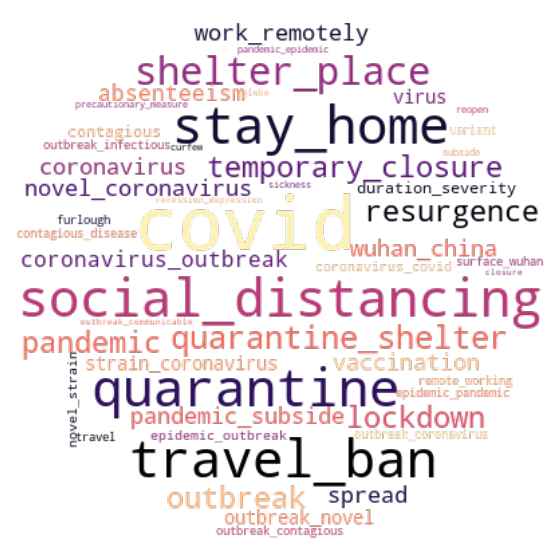

In [52]:
# display the cloud
fig = plt.figure(figsize=(10, 10))
plt.imshow(word_cloud(94), interpolation='bilinear')
plt.axis('off')
plt.show()

In [55]:
wc = word_cloud(94)

In [56]:
wc.to_file("covid.png")